# **Predicción de consumo excesivo de agua en manzanas de la CDMX**

In [250]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [251]:
#pl.Config.set_tbl_rows(18)  # mostrar hasta 18 filas
#pl.Config.set_tbl_cols(20)  # hasta 20 columnas

## **Carga de los datos**

Agregamos *null_values="NA"* porque sin eso polars no puede tratar las cadenas "NA" como valores nulos.

In [252]:
df = pl.read_csv("consumo_agua_historico_2019.csv", null_values="NA") 
print("-- Carga exitosa de los datos con Polars")
print(f"Tipo de dataset: {type(df)}")

-- Carga exitosa de los datos con Polars
Tipo de dataset: <class 'polars.dataframe.frame.DataFrame'>


## **Exploración general de los datos**

Usamos métodos que nos dan una visión completa inicial de la estructura, calidad y forma de los datos.

In [253]:
print(f"--Dimensiones del dataframe (filas, columnas): {df.shape}")

--Dimensiones del dataframe (filas, columnas): (71102, 16)


In [254]:
print("-- Mostramos las primera filas del dataframe")
print(df.head())

print("-- Mostramos las últimas filas del dataframe")
print(df.tail())

-- Mostramos las primera filas del dataframe
shape: (5, 16)
┌────────────┬──────┬──────────┬────────────┬───┬────────────┬────────────┬───────────┬────────────┐
│ fecha_refe ┆ anio ┆ bimestre ┆ consumo_to ┆ … ┆ colonia    ┆ alcaldia   ┆ latitud   ┆ longitud   │
│ rencia     ┆ ---  ┆ ---      ┆ tal_mixto  ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---        │
│ ---        ┆ i64  ┆ i64      ┆ ---        ┆   ┆ str        ┆ str        ┆ f64       ┆ f64        │
│ str        ┆      ┆          ┆ f64        ┆   ┆            ┆            ┆           ┆            │
╞════════════╪══════╪══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════════╡
│ 2019-06-30 ┆ 2019 ┆ 3        ┆ 159.72     ┆ … ┆ 7 DE       ┆ GUSTAVO A. ┆ 19.45526  ┆ -99.112662 │
│            ┆      ┆          ┆            ┆   ┆ NOVIEMBRE  ┆ MADERO     ┆           ┆            │
│ 2019-06-30 ┆ 2019 ┆ 3        ┆ 0.0        ┆ … ┆ 7 DE       ┆ GUSTAVO A. ┆ 19.45526  ┆ -99.112662 │
│            ┆      ┆          

Glosario para mejor entendimiento de las columnas: 
- dom: Uso doméstico (consumo en viviendas o casa habitación)
- no dom: No doméstico (oficinas,escuela, comercio, industrias)
- mixto: Combinación de ambos (Ej. Un predio donde hay vivienda y negocio.)

In [255]:
print("-- Visualizamos nombre y tipo de cada columna")
print(df.schema)

-- Visualizamos nombre y tipo de cada columna
Schema({'fecha_referencia': String, 'anio': Int64, 'bimestre': Int64, 'consumo_total_mixto': Float64, 'consumo_prom_dom': Float64, 'consumo_total_dom': Float64, 'consumo_prom_mixto': Float64, 'consumo_total': Float64, 'consumo_prom': Float64, 'consumo_prom_no_dom': Float64, 'consumo_total_no_dom': Float64, 'indice_des': String, 'colonia': String, 'alcaldia': String, 'latitud': Float64, 'longitud': Float64})


## **Limpieza básica**

- Eliminar duplicados
- Identificar valores nulos o faltantes
- Determinar qué hacer con los valores nulos


In [256]:
print("-- Eliminamos duplicados")
print(df.shape)  # antes
df = df.unique()
print(df.shape)  # después

-- Eliminamos duplicados
(71102, 16)
(69652, 16)


In [257]:
print("-- Contamos valores nulos: ")
print(df.null_count())

-- Contamos valores nulos: 
shape: (1, 16)
┌─────────────────┬──────┬──────────┬────────────────┬───┬─────────┬──────────┬─────────┬──────────┐
│ fecha_referenci ┆ anio ┆ bimestre ┆ consumo_total_ ┆ … ┆ colonia ┆ alcaldia ┆ latitud ┆ longitud │
│ a               ┆ ---  ┆ ---      ┆ mixto          ┆   ┆ ---     ┆ ---      ┆ ---     ┆ ---      │
│ ---             ┆ u32  ┆ u32      ┆ ---            ┆   ┆ u32     ┆ u32      ┆ u32     ┆ u32      │
│ u32             ┆      ┆          ┆ u32            ┆   ┆         ┆          ┆         ┆          │
╞═════════════════╪══════╪══════════╪════════════════╪═══╪═════════╪══════════╪═════════╪══════════╡
│ 0               ┆ 0    ┆ 0        ┆ 8327           ┆ … ┆ 216     ┆ 216      ┆ 0       ┆ 0        │
└─────────────────┴──────┴──────────┴────────────────┴───┴─────────┴──────────┴─────────┴──────────┘


Eliminamos los 216 registros que no tienen colonia ni alcaldía, ya que representan un 0.31% aproximadamente y queremos conocer la ubicación en nuestro análisis.

In [258]:
df = df.filter(
    pl.col("colonia").is_not_null() & pl.col("alcaldia").is_not_null()
)

print(df.shape)

(69436, 16)


In [259]:
# 1. Contar nulos de consumo_total_mixto por alcaldía
nulos_mixto_por_alcaldia = (
    df.filter(pl.col("consumo_total_mixto").is_null())
      .group_by("alcaldia")
      .agg(pl.len())
      .sort("alcaldia")
)
print("Nulos en consumo_total_mixto por alcaldía:")
print(nulos_mixto_por_alcaldia)

# Contar nulos de consumo_total_dom por alcaldía
nulos_dom_por_alcaldia = (
    df.filter(pl.col("consumo_total_dom").is_null())
      .group_by("alcaldia")
      .agg(pl.len())
      .sort("alcaldia")
)
print("Nulos en consumo_total_mixto por alcaldía:")
print(nulos_dom_por_alcaldia)


# 2. Crear columnas binarias para indicar presencia o ausencia de consumo
df = df.with_columns([
    pl.col("consumo_total_mixto").is_not_null().cast(pl.Int8).alias("tiene_mixto"),
    pl.col("consumo_total_dom").is_not_null().cast(pl.Int8).alias("tiene_domestico"),
])

# 3. Imputar nulos con ceros en las columnas de consumo
df = df.with_columns([
    pl.col("consumo_total_mixto").fill_null(0),
    pl.col("consumo_prom_mixto").fill_null(0),
    pl.col("consumo_total_dom").fill_null(0),
    pl.col("consumo_prom_dom").fill_null(0),
])

# Opcional: mostrar cuántos nulos quedan para confirmar
nulos_finales = df.select([
    pl.col(col).null_count().alias(col) for col in [
        "consumo_total_mixto",
        "consumo_prom_mixto",
        "consumo_total_dom",
        "consumo_prom_dom"
    ]
])
print("Nulos después de imputar ceros:")
print(nulos_finales)

Nulos en consumo_total_mixto por alcaldía:
shape: (16, 2)
┌───────────────────────┬─────┐
│ alcaldia              ┆ len │
│ ---                   ┆ --- │
│ str                   ┆ u32 │
╞═══════════════════════╪═════╡
│ ALVARO OBREGON        ┆ 621 │
│ AZCAPOTZALCO          ┆ 295 │
│ BENITO JUAREZ         ┆ 455 │
│ COYOACAN              ┆ 882 │
│ CUAJIMALPA DE MORELOS ┆ 144 │
│ …                     ┆ …   │
│ MILPA ALTA            ┆ 77  │
│ TLAHUAC               ┆ 258 │
│ TLALPAN               ┆ 702 │
│ VENUSTIANO CARRANZA   ┆ 354 │
│ XOCHIMILCO            ┆ 241 │
└───────────────────────┴─────┘
Nulos en consumo_total_mixto por alcaldía:
shape: (16, 2)
┌───────────────────────┬─────┐
│ alcaldia              ┆ len │
│ ---                   ┆ --- │
│ str                   ┆ u32 │
╞═══════════════════════╪═════╡
│ ALVARO OBREGON        ┆ 197 │
│ AZCAPOTZALCO          ┆ 172 │
│ BENITO JUAREZ         ┆ 109 │
│ COYOACAN              ┆ 430 │
│ CUAJIMALPA DE MORELOS ┆ 55  │
│ …                 

In [260]:
print("-- Estadística")
print(df.describe())

-- Estadística
shape: (9, 19)
┌────────────┬────────────┬─────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ fecha_refe ┆ anio    ┆ bimestre ┆ … ┆ latitud   ┆ longitud  ┆ tiene_mix ┆ tiene_dom │
│ ---        ┆ rencia     ┆ ---     ┆ ---      ┆   ┆ ---       ┆ ---       ┆ to        ┆ estico    │
│ str        ┆ ---        ┆ f64     ┆ f64      ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---       │
│            ┆ str        ┆         ┆          ┆   ┆           ┆           ┆ f64       ┆ f64       │
╞════════════╪════════════╪═════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 69436      ┆ 69436.0 ┆ 69436.0  ┆ … ┆ 69436.0   ┆ 69436.0   ┆ 69436.0   ┆ 69436.0   │
│ null_count ┆ 0          ┆ 0.0     ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ null       ┆ 2019.0  ┆ 1.996702 ┆ … ┆ 19.391723 ┆ -99.13244 ┆ 0.880581  ┆ 0.930857  │
│            ┆            ┆         ┆          ┆   ┆         

- Revisamos estadística solo de las columnas numéricas de interés.

In [261]:
import polars.selectors as cs

columnas_consumo = [
    "consumo_total_mixto",
    "consumo_prom_dom",
    "consumo_total_dom",
    "consumo_prom_mixto",
    "consumo_total",
    "consumo_prom",
    "consumo_prom_no_dom",
    "consumo_total_no_dom"
]

df_numerico = df.select(columnas_consumo)
print(df_numerico.describe())


shape: (9, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ consumo_t ┆ consumo_p ┆ consumo_t ┆ … ┆ consumo_t ┆ consumo_p ┆ consumo_p ┆ consumo_ │
│ ---       ┆ otal_mixt ┆ rom_dom   ┆ otal_dom  ┆   ┆ otal      ┆ rom       ┆ rom_no_do ┆ total_no │
│ str       ┆ o         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ m         ┆ _dom     │
│           ┆ ---       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆ f64       ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 69436.0   ┆ 69436.0   ┆ 69436.0   ┆ … ┆ 69436.0   ┆ 69436.0   ┆ 69436.0   ┆ 69436.0  │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆

# **Análisis exploratorio de datos**

## Distribuciones de consumo
Se analizaron varias variables numéricas de consumo; sin embargo, dado que consumo_total representa el agregado general de los diferentes tipos de consumo (doméstico, no doméstico y mixto), se decidió enfocar el análisis en esta variable por ser la más significativa y evitar redundancia,
dado que nos interesa saber el consumo excesivo.

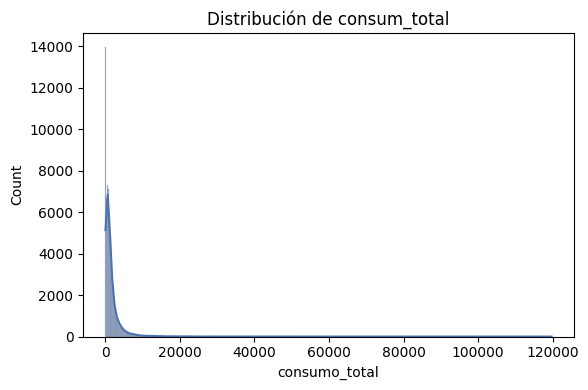

In [262]:
#for col in columnas_consumo:
plt.figure(figsize=(6, 4))
sns.histplot(df["consumo_total"].to_pandas(), kde=True, color="#4C72B0")
plt.title(f"Distribución de {"consum_total"}")
plt.xlabel("consumo_total")
plt.tight_layout()
plt.show()


Observamos una distribución no normal, que está sezgada a la derecha, es decir, la mayoría de los valoress se concentran en "bajos" valores de consumo, mientras que unos pocos representan consumos excesivos.

## Boxplots de consumo total

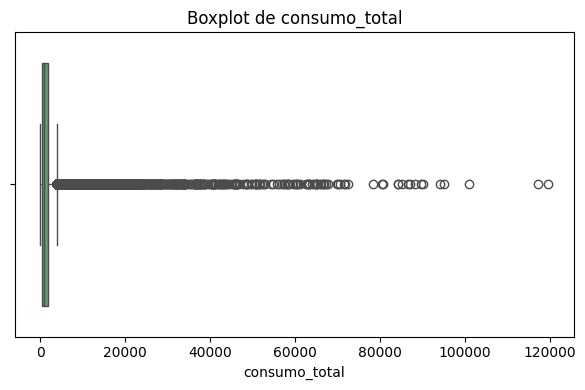

In [263]:
# for col in columnas_consumo:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['consumo_total'].to_pandas(), color="#55A868")
plt.title(f"Boxplot de {'consumo_total'}")
plt.tight_layout()
plt.show()

## Correlación entre variables

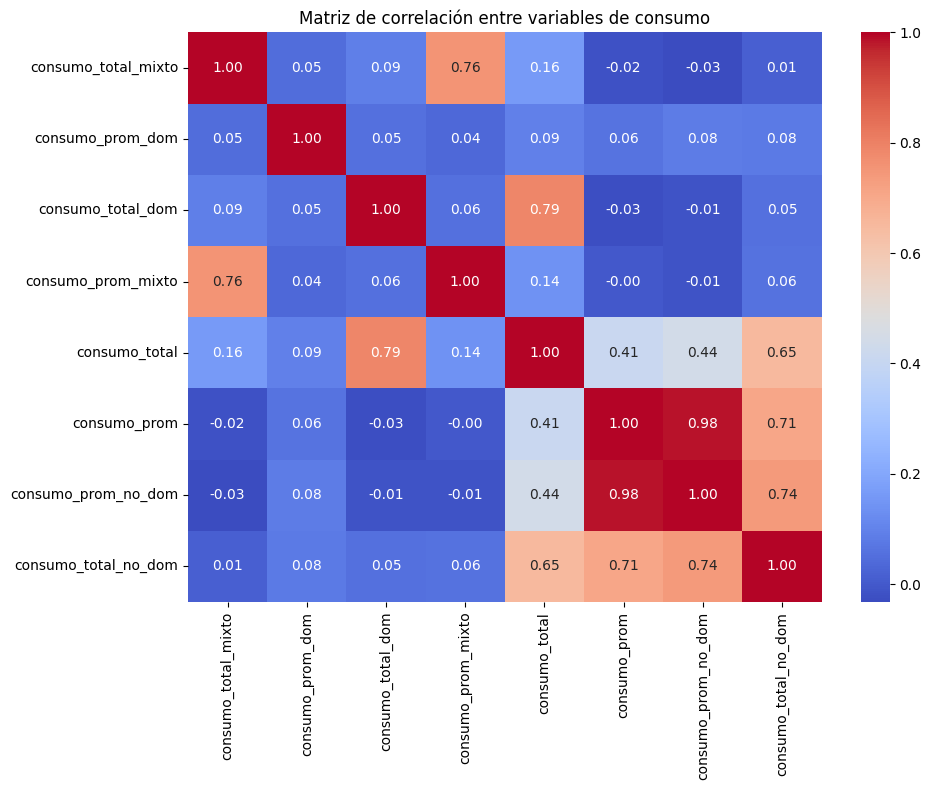

In [264]:
# Convertimos a pandas las columnas numéricas para hacer una matriz de correlación
df_pandas = df.select(columnas_consumo).to_pandas()

# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_pandas.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables de consumo")
plt.tight_layout()
plt.show()


**Algunas observaciones:**
- Se observa una fuerte correlación (0.98) entre consumo_prom_no_dom (no doméstico) y consumo_prom, esto puede indicar que el consumo promedio general está muy influenciado por el no doméstico.
- De igual manera para consumo_total y consumo_total_dom (0.79), el total doméstico contribuye significativamente al total. También hay cierta relación entre consumo_total y consumo_total_no_dom (0.65).
- consumo_prom_dom presentan muy baja correlación con las demás, lo cual sugiere podría representar un patrón único, o tener ruido.

/tmp/ipykernel_16202/2952508145.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="promedio_consumo_total", y="alcaldia", data=df_grouped_pd, palette="Blues_r")


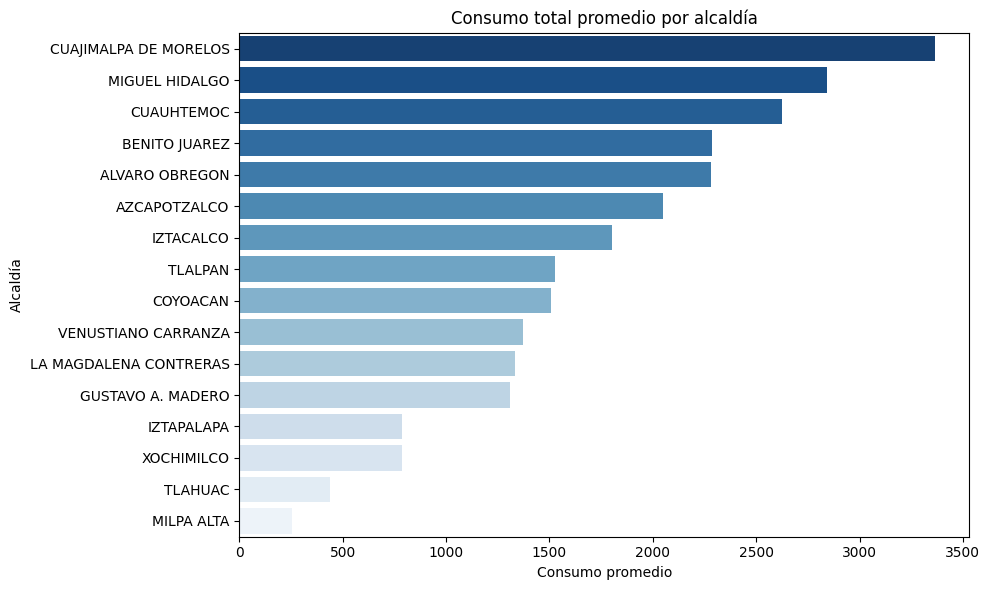

In [265]:
# Agrupar por alcaldía y calcular promedio
df_grouped = (
    df.group_by("alcaldia")
      .agg([
          pl.col("consumo_total").mean().alias("promedio_consumo_total"),
          #pl.col("consumo_prom").mean().alias("promedio_consumo_promedio")
      ])
      .sort("promedio_consumo_total", descending=True)
)

# Graficar en pandas
df_grouped_pd = df_grouped.to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="promedio_consumo_total", y="alcaldia", data=df_grouped_pd, palette="Blues_r")
plt.title("Consumo total promedio por alcaldía")
plt.xlabel("Consumo promedio")
plt.ylabel("Alcaldía")
plt.tight_layout()
plt.show()


Al agrupar por alcaldía, se observa que ciertas zonas tienen en promedio un mayor consumo total de agua, lo que podría estar relacionado con su densidad poblacional o tipo de uso.

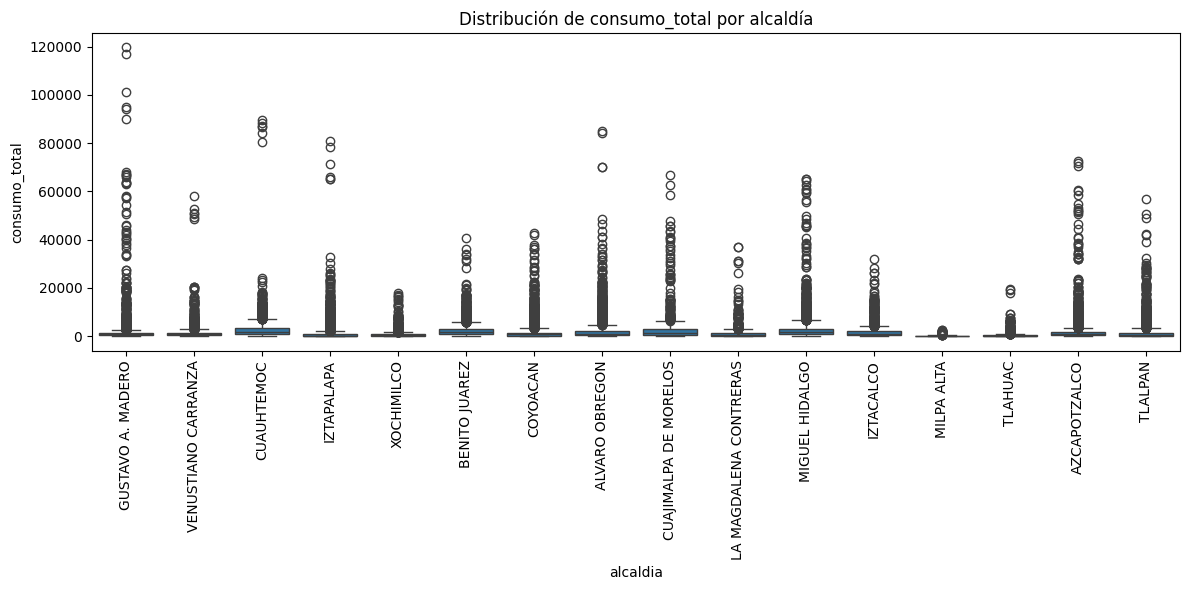

In [266]:
df_pandas = df.to_pandas()

plt.figure(figsize=(12, 6))
sns.boxplot(x="alcaldia", y="consumo_total", data=df_pandas)
plt.xticks(rotation=90)
plt.title("Distribución de consumo_total por alcaldía")
plt.tight_layout()
plt.show()


# **Preprocesamiento técnico**

Crearemos una nueva columna "consumo_excesivo", donde 1 significa que el consumo está por encima del percentil 90 y 0 si está por debajo o igual. Es decir que definimos que una manzana tiene consumo excesivo (1) si su consumo_total está en el 10% más alto del dataset.

In [267]:
# 1. Calcula el percentil 90
p90 = df.select(pl.col("consumo_total").quantile(0.9, "nearest")).item()

# 2. Crea columna binaria
df = df.with_columns(
    (pl.col("consumo_total") > p90).cast(pl.Int8).alias("consumo_excesivo")
)

# 3. Cuenta cuántos hay por clase
df.select("consumo_excesivo").group_by("consumo_excesivo").len()
#df.select("consumo_excesivo").group_by("consumo_excesivo").count()



consumo_excesivo,len
i8,u32
1,6943
0,62493


Se codificó la variable categórica alcaldía mediante One-Hot Encoding, transformando cada categoría en una columna binaria. Esta técnica permite incluir variables categóricas en modelos de Machine Learning que solo aceptan variables numéricas. En este caso la variable categórica fue transformada en columnas binarias como *alcaldia_IZTAPALAPA*

In [268]:
# One-hot encoding de alcaldía
df = df.to_dummies(columns=["alcaldia"])


Visualización de la distribución logarítmica:

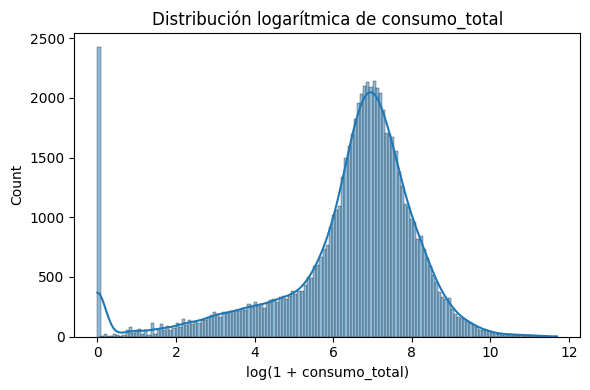

In [269]:
plt.figure(figsize=(6, 4))
sns.histplot(np.log1p(df["consumo_total"].to_pandas()), kde=True)
plt.title("Distribución logarítmica de consumo_total")
plt.xlabel("log(1 + consumo_total)")
plt.tight_layout()
plt.show()


In [270]:
df = df.with_columns(
    pl.col("consumo_total").log1p().alias("log_consumo_total")
)


Escalado MIn-Max, para transformar los valores numéricos a un rango de 0 a 1, ya que variables como *latitud*, *longitud*, *log_consumo_total* tienen escalas muy distintas. Y los modelos son sensibles a las escalas.

In [271]:
# Función para min-max scaling en Polars
def min_max_scale(df, col_name):
    min_val = df.select(pl.col(col_name).min()).item()
    max_val = df.select(pl.col(col_name).max()).item()
    return ((pl.col(col_name) - min_val) / (max_val - min_val)).alias(f"{col_name}_scaled")

# Aplica el escalado
df = df.with_columns([
    min_max_scale(df, "log_consumo_total"),
    min_max_scale(df, "latitud"),
    min_max_scale(df, "longitud")
])


In [272]:
# X: variables predictoras
# y: variable objetivo

X = df.select([
    "log_consumo_total_scaled", 
    "latitud_scaled", 
    "longitud_scaled",
    *[col for col in df.columns if col.startswith("alcaldia_")]
])

y = df.select("consumo_excesivo")


# **Entrenamiento del modelo**

## Regresión Logística

In [273]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [274]:
X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(),  # conviertes de Polars a pandas
    y.to_pandas().squeeze(),  # Series en lugar de DataFrame
    test_size=0.2,
    random_state=42,
    stratify=y.to_pandas()  # para mantener proporción de clases
)


Entrenamiento del modelo:

In [275]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Evaluación del modelo

In [276]:
y_pred = model.predict(X_test)

print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Matriz de confusión:
 [[12499     0]
 [  183  1206]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     12499
           1       1.00      0.87      0.93      1389

    accuracy                           0.99     13888
   macro avg       0.99      0.93      0.96     13888
weighted avg       0.99      0.99      0.99     13888



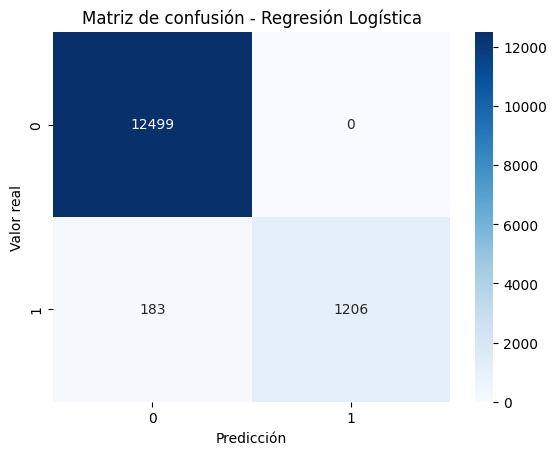

In [277]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Regresión Logística")
plt.show()

**Regresión Logística considerando bimestres**

In [278]:
# Ordenar por año y bimestre
df.select(["anio", "bimestre"]).unique().sort(["anio", "bimestre"])




anio,bimestre
i64,i64
2019,1
2019,2
2019,3


In [279]:
# Ordenar por tiempo
df = df.sort(["anio", "bimestre"])

# Año y bimestre más recientes
ultimo_anio = df.select("anio").max().item()
ultimo_bimestre = df.filter(pl.col("anio") == ultimo_anio).select("bimestre").max().item()


In [280]:
# Entrenamiento = todos los bimestres anteriores
df_train = df.filter(
    (pl.col("anio") < ultimo_anio) |
    ((pl.col("anio") == ultimo_anio) & (pl.col("bimestre") < ultimo_bimestre))
)

# Prueba = último bimestre
df_test = df.filter(
    (pl.col("anio") == ultimo_anio) & (pl.col("bimestre") == ultimo_bimestre)
)


In [281]:
# Columnas predictoras
cols_predictoras = [
    "log_consumo_total_scaled", 
    "latitud_scaled", 
    "longitud_scaled",
    *[col for col in df.columns if col.startswith("alcaldia_")]
]

# X e y para entrenamiento y prueba
X_train = df_train.select(cols_predictoras).to_pandas()
y_train = df_train.select("consumo_excesivo").to_pandas().squeeze()

X_test = df_test.select(cols_predictoras).to_pandas()
y_test = df_test.select("consumo_excesivo").to_pandas().squeeze()


In [282]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[20673     0]
 [  348  2016]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20673
           1       1.00      0.85      0.92      2364

    accuracy                           0.98     23037
   macro avg       0.99      0.93      0.96     23037
weighted avg       0.99      0.98      0.98     23037



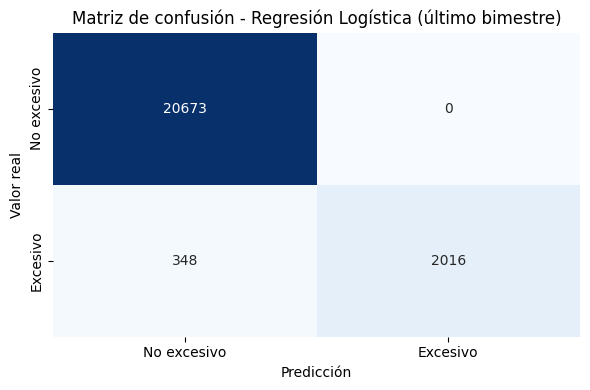

In [283]:
# Genera la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Define las etiquetas
labels = ["No excesivo", "Excesivo"]

# Dibuja el heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Regresión Logística (último bimestre)")
plt.tight_layout()
plt.show()

- 20673 verdaderos negativos: el modelo predijo correctamente que no habría consumo excesivo.

- 2016 verdaderos positivos: el modelo predijo correctamente que sí habría consumo excesivo.

- 348 falsos negativos: hubo consumo excesivo real, pero el modelo no lo predijo.

- 0 falsos positivos: el modelo nunca predijo que habría consumo excesivo cuando no lo había :)